# Multi-layer neural network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.set_random_seed(2017)

# 构建数据

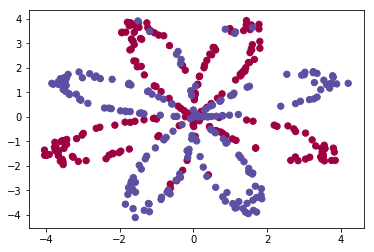

In [2]:
m = 400 # 样本数量
N = int(m/2) # 每一个类别样本数
D= 2# 维度

x = np.zeros((m,D))
y = np.zeros((m,1), dtype=np.uint8) # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j, N*(j+1))
    t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

plt.scatter(x[:, 0], x[:, 1], c=np.squeeze(y), s=40, cmap=plt.cm.Spectral)


我们可以先尝试用logistic回归模型来解决这个分类问题

In [3]:
#构造模型
x = tf.constant(x, dtype=tf.float32, name='x')
y = tf.constant(y, dtype=tf.float32, name='y')

#定义参数
w = tf.Variable(tf.random_normal(shape=(2,1)) ,dtype=tf.float32,
                name='weights')
b = tf.Variable(tf.zeros((1)), dtype=tf.float32,
                name='bias')

def logistic_model(x):
    logit = tf.sigmoid(tf.matmul(x,w)+b)
    return logit

y_pred = logistic_model(x)

In [4]:
#构造训练
loss = tf.losses.log_loss(labels=y, predictions=y_pred)
lr = 1e-1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

In [5]:
#执行训练
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
for i in range(1000):
    sess.run(train_op)
    if (i+1)%100==0:
        loss_numpy = loss.eval()
        print('Epoch %d  Loss %.6f'%(i+1,loss_numpy))    

Epoch 100  Loss 0.667762
Epoch 200  Loss 0.667721
Epoch 300  Loss 0.667721
Epoch 400  Loss 0.667721
Epoch 500  Loss 0.667721
Epoch 600  Loss 0.667721
Epoch 700  Loss 0.667721
Epoch 800  Loss 0.667721
Epoch 900  Loss 0.667721
Epoch 1000  Loss 0.667721


看上去loss并没有下降, 那么我们再来看看模型的效果

In [6]:
# 显示分类结果
def plot_decision_boundary(model, x, y):
    # 找到x, y的最大值和最小值, 并在周围填充一个像素
    x_min, x_max = x[:, 0].min() -1, x[:, 0].max() +1
    y_min, y_max = x[:, 1].min() -1, x[:, 1].max() +1
    h = 0.01
    # 构建一个宽度为`h`的网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    # 计算模型在网格上所有点的输出值
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # 画图显示
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=np.squeeze(y), cmap=plt.cm.Spectral)

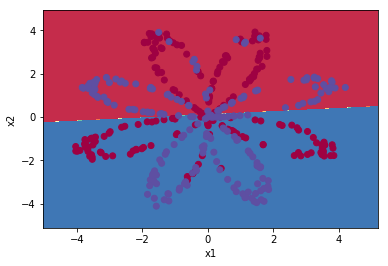

In [7]:
model_input = tf.placeholder(shape=(None, 2), dtype=tf.float32, name='logistic_input')
logistic_output = logistic_model(model_input)
def plot_logistic(x_data):
    y_pred_numpy = sess.run(logistic_output, 
                            feed_dict={model_input: x_data})
    out = np.greater(y_pred_numpy, 0.5).astype(np.float32)
    return np.squeeze(out)

plot_decision_boundary(plot_logistic, x.eval(), y.eval())

# 深度神经网络

In [8]:
# 首先构建第一个隐藏层
with tf.variable_scope('layer1'):
    w1 = tf.Variable(tf.random_normal(shape=(2,4), stddev=0.01),
                     name='weight1')
    b1 = tf.Variable(tf.zeros(shape=(4)),  name='bias1')

# 同样地, 我们再构建第二个隐藏层    
with tf.variable_scope('layer2'):
    w2 = tf.Variable(tf.random_normal(shape=(4,1), stddev=0.01),
                     name='weight2')
    b2 = tf.Variable(tf.zeros(shape=(1)), name='bias2')

# 定义神经网络
def two_network(nn_input):
    with tf.variable_scope('two_network'):
        net = tf.matmul(nn_input,w1)+b1
        net = tf.tanh(net)
        net = tf.matmul(net,w2)+b2
        net = tf.sigmoid(net)
        return net        

In [9]:
#构造网络
net = two_network(x)

#构造训练
loss_two = tf.losses.log_loss(labels=y, predictions=net, scope='loss_two')
lr = 1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss_two)

# 模型的保存
在我们开始训练之前, 我们先思考一下, 在之前的过程中, 当模型的参数经过训练之后, 模型的效果得以显示, 而模型的参数却没有得到保存, 那么下次我们希望得到一个比较好的结果的时候, 又必须得重新训练, 这是令人难以接受的.因此, 我们需要将模型保存到本地, 并且需要一种正确的方式将模型读入到内存中来.<br>
Tensorflow提供了tf.train.Saver类来管理模型的保存与加载

In [10]:
saver = tf.train.Saver()

接着, 在我们训练的过程中, 随时可以调用saver的save函数去保存中间过程的参数, 它会把模型存放在.ckpt文件中下面我们试着对这个模型训练10000次, 并且在第5000步以及最后一步各保存一次模型

In [11]:
# 执行训练
sess.run(tf.global_variables_initializer())
for i in range(10000):
    sess.run(train_op)
    if (i+1) % 500 ==0:
        loss_numpy = loss_two.eval()
        print('Epoch %d Loss %.6f'%(i+1,loss_numpy))
    if (i+1)% 5000 ==0:
        # `sess`参数表示开启模型的`session`, 必选参数
        # `save_path`参数表示模型保存的路径, 必须要以`.ckpt`结尾
        # `global_step`参数表示模型当前训练的步数, 可以用来标记不同阶段的模型
        saver.save(sess=sess, save_path='save/model.ckpt', global_step=(i+1))
        print('model-%d saved'%(i+1))

Epoch 500 Loss 0.291674
Epoch 1000 Loss 0.265792
Epoch 1500 Loss 0.258011
Epoch 2000 Loss 0.251234
Epoch 2500 Loss 0.246614
Epoch 3000 Loss 0.243062
Epoch 3500 Loss 0.240157
Epoch 4000 Loss 0.237718
Epoch 4500 Loss 0.235624
Epoch 5000 Loss 0.233786
model-5000 saved
Epoch 5500 Loss 0.232144
Epoch 6000 Loss 0.230659
Epoch 6500 Loss 0.229310
Epoch 7000 Loss 0.228083
Epoch 7500 Loss 0.226965
Epoch 8000 Loss 0.225944
Epoch 8500 Loss 0.225010
Epoch 9000 Loss 0.224153
Epoch 9500 Loss 0.223366
Epoch 10000 Loss 0.222640
model-10000 saved


First_Save/<br>├── checkpoint<br>├── model.ckpt-10000.data-00000-of-00001<br>├── model.ckpt-10000.index<br>├── model.ckpt-10000.meta<br>├── model.ckpt-5000.data-00000-of-00001<br>├── model.ckpt-5000.index<br>└── model.ckpt-5000.meta


可以看到, model.ckpt-5000和model.ckpt-10000都是保存好的模型, 而他们又都有.data-00000-of-00001,.meta和.index三个文件. 这是由于tensorflow在保存的过程中同时保存了模型的定义和模型参数的值, 然后又分开不同的文件存放, 以后我们会具体谈到如何应用这三个文件, 暂时我们只需要理解model.ckpt-***就是我们保存好的模型就行了训练完成之后, 我们先看一下模型训练的效果如何

Text(0.5, 1.0, '2 layer network')

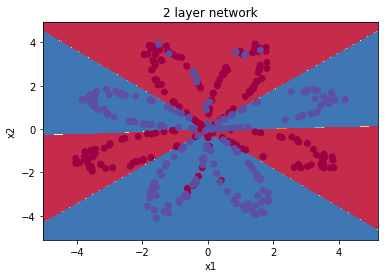

In [12]:
nn_out = two_network(model_input)
def plot_network(input_data):
    y_pred_numpy = sess.run(nn_out, 
                            feed_dict={model_input: input_data})
    out = np.greater(y_pred_numpy, 0.5).astype(np.float32)
    return np.squeeze(out)
plot_decision_boundary(plot_network, x.eval(), y.eval())
plt.title('2 layer network')

可以看到, 2层神经网络的效果明显优于logistic回归的效果<br>
那么接下来我们再看看如何从本地导入模型以及参数

In [13]:
# 首先关闭当前会话
sess.close()

现在重新打开一个session, 会如何呢?

In [14]:
sess = tf.InteractiveSession()

try:
    print(w1.eval())
except tf.errors.FailedPreconditionError as e:
    print('err!!!\n',e.message)

err!!!
 Attempting to use uninitialized value layer1/weight1
	 [[{{node layer1/weight1/_0}} = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_layer1/weight1", _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1/weight1)]]
	 [[{{node layer1/weight1/_1}} = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_layer1/weight1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


因为我们确实没有初始化参数的值. 但是, 如果我们用tf.global_variables_initializer()这一类函数去初始化的话, 之前训练好的模型参数就是无用功了, 这种事情当然可以避免了

# 模型的恢复
加载模型也叫做模型的恢复, 包括两个阶段
- 首先, 恢复模型的结构
- 再恢复模型的参数值

In [15]:
# 恢复模型结构
saver = tf.train.import_meta_graph('save/model.ckpt-10000.meta')

# 恢复模型参数
saver.restore(sess, 'save/model.ckpt-10000')

INFO:tensorflow:Restoring parameters from save/model.ckpt-10000


In [16]:
# 打印一下w1的数值
print(w1.eval())

[[  8.122429     0.26826954  -0.80471706  11.21173   ]
 [  9.15591     -7.5382943   -7.396525   -13.120174  ]]


Text(0.5, 1.0, '2 layer network')

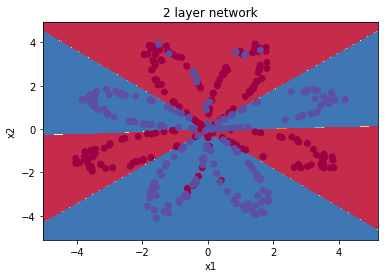

In [17]:
# 重新可视化一下分类结果
plot_decision_boundary(plot_network, x.eval(session=sess), y.eval(session=sess))
plt.title('2 layer network')